# SimCLR with PL + Downstream

List of full videos is here:    

https://www.youtube.com/playlist?list=PLaMu-SDt_RB4k8VXiB3hOdsn0Y3GoXo1k

Pretrained simCLR2: https://console.cloud.google.com/storage/browser/simclr-checkpoints/simclrv2/pretrained?pageState=(%22StorageObjectListTable%22:(%22f%22:%22%255B%255D%22))&prefix=&forceOnObjectsSortingFiltering=false

In [ ]:
%%capture
! pip install pytorch-lightning-bolts
! pip install pytorch-lightning
! pip install wandb
! pip install lightning-flash -U
! pip install Pillow==4.0.0
! pip install PIL
! pip install image
! pip install IPython ipykernel --update
# %reload_ext autoreload
# %autoreload
# !pip install transformers~=2.11.0

## Importing libraries and Dataset

In [1]:
import torch
import pytorch_lightning as pl
from pl_bolts.models.self_supervised import SimCLR
from pl_bolts.callbacks.ssl_online import SSLOnlineEvaluator
from pl_bolts.models.self_supervised.simclr.transforms import (
    SimCLREvalDataTransform, SimCLRTrainDataTransform)

from pytorch_lightning.loggers import WandbLogger

#Lightning Flash module
# from flash import Trainer
from flash import download_data
# from flash.vision import ImageClassificationData, ImageClassifier

import zipfile
import os
import pandas as pd
import numpy as np
import torch
import torchvision

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
#load data with Flash

download_data("https://ml701.s3.me-south-1.amazonaws.com/OCT2017_M.zip", "data/")

In [30]:
#explore csv

'''
0: NORMAL
1: CNV
2: DME
3: DRUSEN
'''
random_state = 6
num_of_classes = 4
frac_train_images = .6
root_dir = 'data/OCT2017_M'
total_train = pd.read_csv(f"{root_dir}/train.csv")
data = total_train.sample(frac=frac_train_images, random_state=random_state)
print(f"total train data size: {total_train.shape}, sample train data size: {data.shape}")

total train data size: (5200, 2), sample train data size: (3120, 2)


### Defining Dataloader and Transformer

In [24]:
#dataset
from  pl_bolts.datamodules.async_dataloader import AsynchronousLoader
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class OCTDataset(Dataset):
    """ OCT Dataset """
    
    def __init__(self, root_dir, frac_train_images=1, transform=None, stage=False, random_state=1):
        if stage: 
            csv_output = pd.read_csv(os.path.join(root_dir, "test.csv"))
            self.images_dir = os.path.join(root_dir, "test")
        else:
            total_csv_output = pd.read_csv(os.path.join(root_dir, "train.csv"))
            csv_output = total_csv_output.sample(frac=frac_train_images, 
                                                 random_state=random_state)
            self.images_dir = os.path.join(root_dir, "train")

        self.image_urls = np.asarray(csv_output["image_id"])
        self.labels = np.asarray(csv_output["label"])
        self.transform = transform
        
    def __len__(self):
        return len(self.image_urls)
    
    def __getitem__(self, idx):
        # Get and load image
        image_path = os.path.join(self.images_dir, self.image_urls[idx])
        image = Image.open(image_path)
        # Perform transforms if any
        if self.transform:
            image = self.transform(image)
        # Get label
        label = self.labels[idx]   
        return image, label

In [25]:
#datamodule
from torch.utils.data import random_split
from torch.utils.data import RandomSampler
import math

class OCTDataModule(pl.LightningDataModule):
    """ OCT DataModule for Lightning """
    def __init__(self, root_dir, frac_train_images=1, transform=None, batch_size=32, random_state=1):
        super().__init__()
        self.batch_size = batch_size
        self.root_dir = root_dir
        self.transform = transform
        self.frac_train_images = frac_train_images
        self.random_state = random_state
        
    def setup(self, stage=None):
        oct_full = OCTDataset(root_dir=self.root_dir, transform=self.transform, 
                              frac_train_images=self.frac_train_images, 
                              random_state=self.random_state)
        train_data_len = math.floor(len(oct_full) * 0.7)
        val_data_len = len(oct_full) - train_data_len
        # Create train and validation datasets
        self.oct_train, self.oct_val = random_split(oct_full, [train_data_len, val_data_len], 
                                                    generator=torch.Generator().manual_seed(random_state))
        
        # Create test dataset
        self.oct_test = OCTDataset(root_dir=self.root_dir, transform=self.transform, stage=True)

    def train_dataloader(self):
        return DataLoader(self.oct_train, batch_size=self.batch_size,
                          num_workers=32)
    
    def val_dataloader(self):
        return DataLoader(self.oct_val, batch_size=self.batch_size, 
                          num_workers=32)
    
    def test_dataloader(self):
        return DataLoader(self.oct_test, batch_size=self.batch_size, 
                          num_workers=32)

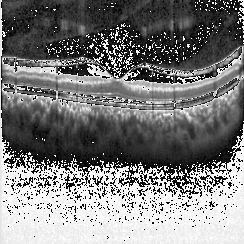

In [26]:
#transforms on OCT data
import torchvision.transforms as transforms
from pl_bolts.models.self_supervised.simclr.transforms import SimCLRTrainDataTransform
import torchvision.transforms.functional as tvf

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((244, 244)),
    # transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # ImageNet Normalization
    ])

random_state = 6
num_of_classes = 4
frac_train_images = .6
root_dir = 'data/OCT2017_M'
oct_data = OCTDataModule(root_dir=root_dir, transform=transform, batch_size=64, 
                         frac_train_images=frac_train_images, random_state=random_state)
oct_data.setup()

ds_train = oct_data.oct_train
# ds_train[img_index][][channel]
tvf.to_pil_image(ds_train[6][0][0])

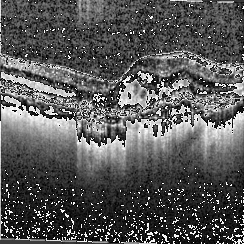

In [27]:
ds_test = oct_data.oct_test
# ds_test[img_index][][channel]
tvf.to_pil_image(ds_test[6][0][0])

## Fine-tuning & Classifier

In [5]:
# unfreeze params post warm-up.  Can be used with any model.
from pytorch_lightning.callbacks import Callback
class UnFreezeCallback(Callback): 
    def on_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch == 10:
            pl_module.embeddings.unfreeze()

In [6]:
# model
#load simCLR pre-trained on imagenet
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from pl_bolts.models import LinearRegression, LogisticRegression
import torchvision.models as models
import wandb

class OCTModel(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        hparams = Namespace(**hparams) if isinstance(hparams, dict) else hparams
        self.hparams = hparams
        
        base_model = SimCLR.load_from_checkpoint(hparams.embeddings_path, strict=False)
        
        # Set our learning rate
        self.learning_rate = hparams.learning_rate   
        self.tune = hparams.tune

        num_target_classes = hparams.n_classes
        self.embeddings = base_model
        
        #freeze
        if hparams.freeze_base:
            self.embeddings.eval()  

        # Use the pretrained simclr model representations to classify oct. 
#         self.classifier = nn.Linear(self.embeddings.encoder.fc.in_features, num_target_classes)
        self.classifier = nn.Sequential(
            nn.Linear(self.embeddings.encoder.fc.in_features, 
                      self.embeddings.encoder.fc.in_features),
            nn.ReLU(),
            nn.Linear(self.embeddings.encoder.fc.in_features, 
                      num_target_classes if num_target_classes > 2 else 1),
        )
        
        # Create loss function
        self.loss_fn = torch.nn.CrossEntropyLoss()
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer
    
    def forward(self, input_data):
        # input = input_data[0].unsqueeze(0)
        # input = input.view(64, 3, 244,244)
        representations = self.embeddings(input_data)
        preds = self.classifier(representations)
        # preds = self.classifier(representations[0])
        return preds
    
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        predictions = self.forward(x)
        loss = self.loss_fn(predictions, y)

        if not self.tune:
            self.logger.experiment.log({"train_input_image":[wandb.Image(train_batch[0][0].cpu(), 
                                                                         caption="train_input_image")]},
                                       commit=False)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        predictions = self.forward(x)
        loss = self.loss_fn(predictions, y)

        if not self.tune:
            self.logger.experiment.log({"val_input_image":[wandb.Image(val_batch[0][0].cpu(), 
                                                                       caption="val_input_image")]},
                                       commit=False)
        self.log('val_loss', loss)

### Finding best Learning rate parameter for initialization

In [7]:
from argparse import Namespace

weight_path = 'https://pl-bolts-weights.s3.us-east-2.amazonaws.com/simclr/bolts_simclr_imagenet/simclr_imagenet.ckpt'
hparams = Namespace(
    learning_rate=1e-3,
    freeze_base=True,
    tune=False,
    epochs=50,
    n_classes=4,
    embeddings_path=weight_path
)

#init model
model = OCTModel(hparams)

#tune
trainer = pl.Trainer(gpus=1)
lr_finder = trainer.tuner.lr_find(model,datamodule=oct_data)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | embeddings | SimCLR           | 30.0 M
1 | classifier | Sequential       | 4.2 M 
2 | loss_fn    | CrossEntropyLoss | 0     
------------------------------------------------
34.2 M    Trainable params
0         Non-trainable params
34.2 M    Total params
136.897   Total estimated model params size (MB)


Restored states from the checkpoint file at /home/student/Documents/DS/PML/Pretrained Method/lr_find_temp_model.ckpt


0.001584893192461114


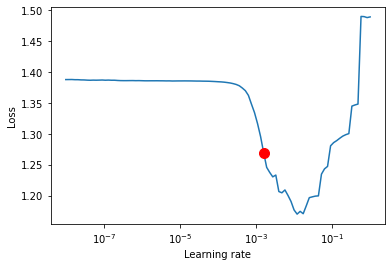

In [8]:
# Inspect results
lr_finder.plot(show=False, suggest=True)
suggested_lr = lr_finder.suggestion()
print(suggested_lr)

### Running Classifier model with best initialization parameters

In [9]:
# Overwrite lr and create new model
weight_path = 'https://pl-bolts-weights.s3.us-east-2.amazonaws.com/simclr/bolts_simclr_imagenet/simclr_imagenet.ckpt'
hparams = Namespace(
    learning_rate=suggested_lr,
    freeze_base=True,
    tune=False,
    max_epochs=15,
    n_classes=4,
    embeddings_path=weight_path
)

model_tuned = OCTModel(hparams)

In [14]:
from datetime import datetime

#init logger
experiment_num="03"
date=datetime.today().strftime('%Y%m%d')
experiment_name=f"OCT_exp_complex_classifier_{in(frac_train_images * 100)}train_{experiment_num}_{date}" 
experiment_id=f"complex_classifier_{experiment_num}_{date}"
project_name="simCLR-ml701"

wandb_logger = WandbLogger(name=experiment_name,
                           project=project_name, 
                           id=experiment_id, log_model=True)
wandb_logger.watch(model_tuned, log="all", log_freq=50)

#cp
checkpoint_callback=pl.callbacks.ModelCheckpoint(
    dirpath=experiment_name + '_ckp',
    monitor='val_loss',
    filename='{epoch}-{train_loss:.2f}-{val_loss:.2f}'    
)

# fit
trainer = pl.Trainer(max_epochs=hparams.max_epochs,
                     progress_bar_refresh_rate=20,
                     gpus=1,
                     logger=wandb_logger,
                     callbacks=[checkpoint_callback, UnFreezeCallback()])
trainer.fit(model_tuned, datamodule=oct_data)



#save checkpoint with weights
checkpoint_file=experiment_name + "_pretrained.ckpt"
trainer.save_checkpoint(checkpoint_file)
#save to W&B
trainer.logger.experiment.log_artifact(checkpoint_file, type="model")

wandb: Currently logged in as: dsaenzpe (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.21 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | embeddings | SimCLR           | 30.0 M
1 | classifier | Sequential       | 4.2 M 
2 | loss_fn    | CrossEntropyLoss | 0     
------------------------------------------------
34.2 M    Trainable params
0         Non-trainable params
34.2 M    Total params
136.897   Total estimated model params size (MB)


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


In [16]:
# end run on W&B + sync results
# import wandb
wandb.finish()
# wandb_logger.finalize('success')

train_loss,0.05317
_timestamp,1614860572
_step,1049
val_loss,0.17868
epoch,14
_runtime,672


_runtime,▁▁▁▂▂▂▃▃▃▃▄▄▄▄▅▅▆▆▆▆▆▇▇▇█
_timestamp,▁▁▁▂▂▂▃▃▃▃▄▄▄▄▅▅▆▆▆▆▆▇▇▇█
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▆▆▆▇▇▇███
val_loss,▄▅▃▁▁▂▁▃▂█▂▂▂▂▁
epoch,▁▁▁▂▂▃▃▃▃▃▄▅▅▅▅▅▆▇▇▇▇▇██
train_loss,█▂▁▃▁▁▁▁▁▃


## Evaluation

In [28]:
from sklearn.metrics import classification_report

def evaluate(data_loader,module):
    with torch.no_grad():
        print('start')
        module.eval() 
        print('eval')
        progress = ["/", "-", "\\", "|", "/", "-", "\\", "|"]
        true_y, pred_y = [], []
        print('ready')
        for i, _batch in enumerate(data_loader):
            print('iteration')
            print(progress[i % len(progress)], end="\r")
            x, y = _batch    
            y_pred = torch.argmax(module(x), dim=1)
            true_y.extend(y)
            pred_y.extend(y_pred)
        print('report')
        print(classification_report(true_y, pred_y, digits=3))
        print('return')
        return true_y, pred_y

In [29]:
# Evaluate predictions on test data
ds_test = oct_data.test_dataloader()

_ = evaluate(ds_test, model_tuned)

start
eval
ready
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
report
              precision    recall  f1-score   support

           0      1.000     0.992     0.996       250
           1      0.996     0.920     0.956       250
           2      0.936     1.000     0.967       250
           3      0.976     0.992     0.984       250

    accuracy                          0.976      1000
   macro avg      0.977     0.976     0.976      1000
weighted avg      0.977     0.976     0.976      1000

return
